In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import hydra 
import transformers
import os
from peft import LoraConfig, get_peft_model
from pathlib import Path
from omegaconf import OmegaConf
import json
import transformers
import torch
import os
import json
import random
import numpy as np
import argparse
from typing import Dict, List, Optional, Iterator, Callable, Union, Tuple
import datasets
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import sys
import re
from rouge_score import rouge_scorer
from collections import defaultdict
import re
from copy import  deepcopy
from torch.utils.data import Dataset

/home/asetlur/anaconda3/envs/syth-llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
configs = {
    'question_start_tag': "[INST] ",
    "question_end_tag": " In the end, output the final answer after '####'. [/INST]",
    "answer_tag": "",
    'max_length': 512,
    'model_id': "mistralai/Mistral-7B-Instruct-v0.1",
    'batch_size': 64,
    'num_epochs': 20,
    'gradient_accumulation_steps': 1,
    'lr': 1e-5,
    'weight_decay': 1e-4,
    'save_dir': 'gsm8k_mistral7b_instruct',
}

In [4]:
def delete_extra_zero(n):
    try:
        n=float(n)
    except:
        # print("None {}".format(n))
        return n
    if isinstance(n, int):
        return str(n)
    if isinstance(n, float):
        n = str(n).rstrip('0')  
        n = int(n.rstrip('.')) if n.endswith('.') else float(n)  
        n=str(n)
        return n
    
    
def read_jsonl(path: str):
    with open(path) as fh:
        return [json.loads(line) for line in fh.readlines() if line]

def get_examples(split):
    path = os.path.join("data/", f"{split}.jsonl")
    examples = read_jsonl(path)

    for ex in examples:
        ex.update(question=configs['question_start_tag'] + ex["question"] + configs['question_end_tag'])
        ground_truth = delete_extra_zero(ex["answer"].split("#### ")[-1].replace(",", ""))
        ex.update(answer=ex["answer"] + "<|endoftext|>")
        ex.update(ground_truth=ground_truth)
        

    print(f"Originally {len(examples)} {split} examples")
    return examples



def convert_raw_data_to_model_format(tokenizer, max_length, question, answer, gt_answer, configs):
    question_start_token, question_end_token, answer_token = configs['question_start_tag'], configs['question_end_tag'], configs['answer_tag']
    new_question = question_start_token + question + question_end_token
    new_answer = answer_token + answer
    full_text = new_question + new_answer
    num_question_tokens = len(tokenizer.tokenize(new_question, add_special_tokens=True))

    encoded = tokenizer(
        full_text, 
        add_special_tokens=True, 
        max_length=max_length, 
        truncation=True, 
    )
    # pad_length = max_length - len(encoded.input_ids)
    # pad_input_ids = encoded['input_ids'] 
    # pad_attention_mask = encoded['attention_mask'] 
    # label = encoded.input_ids
    labels = deepcopy(encoded.input_ids)
    encoded['labels'] = labels
    encoded['question_length'] = num_question_tokens
    encoded['question'] = new_question
    encoded['answer'] = new_answer
    encoded['gt_answer'] = gt_answer
    
    
    
    #change label to -100 for question tokens
    for i in range(num_question_tokens): encoded['labels'][i] = -100
    return encoded

    # return encoded.input_ids, encoded.attention_mask, torch.tensor(label)
    



class TextDatasetQA(Dataset):
    def __init__(self, tokenizer, configs, frac = 1.0, split = None):
        super(TextDatasetQA, self).__init__()
        self.tokenizer = tokenizer
        self.max_length = configs['max_length']
        examples = get_examples(split)
        N = int(frac * len(examples))
        self.data = examples[:N]
        self.configs = configs 
        print(f"Returning {len(self.data)} {split} examples")
    

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        question = self.data[idx]['question']
        answer = self.data[idx]['answer']
        gt_answer = self.data[idx]['ground_truth']  
        converted_data = convert_raw_data_to_model_format(
            self.tokenizer, self.max_length, question, answer, gt_answer, self.configs)

        return converted_data

        # pad_input_ids_list = []
        # label_list = []
        # pad_attention_mask_list = []
        # pad_input_ids_list.append(converted_data[0])
        # label_list.append(converted_data[1])
        # pad_attention_mask_list.append(converted_data[2])
        # return encoded
        # torch.stack(label_list).squeeze(),\
        # torch.stack(pad_attention_mask_list).squeeze()


# def collate_fn(batch):
#     input_ids, attention_masks = zip(*batch)
#     input_ids = pad_sequence(input_ids, batch_first=True, padding_value=-100)
#     attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
#     return input_ids, attention_masks


def get_collate_fn(tokenizer) -> Callable[[List[Dict]], Dict[str, Union[List, torch.Tensor]]]:
    """Returns a collate function for the given tokenizer.
       The collate function takes a list of examples (dicts, where values are lists of
       ints [tokens] or strings [the original texts]) and returns a batch of examples,
       PyTorch tensors padded to the maximum length. Strings are passed through."""
    def collate_fn(batch):
        # first, pad everything to the same length
        padded_batch = {}
        for k in batch[0].keys():
            if k.endswith('input_ids') or k.endswith('attention_mask') or k.endswith('labels'):
                to_pad = [torch.LongTensor(ex[k][::-1]) for ex in batch]
                if k.endswith('input_ids'):
                    padding_value = tokenizer.pad_token_id
                elif k.endswith('attention_mask'):
                    padding_value = 0
                elif k.endswith('labels'):
                    padding_value = -100
                else:
                    raise ValueError(f"Unexpected key in batch '{k}'")
                padded_batch[k] = pad_sequence(to_pad, batch_first=True, padding_value=padding_value)
                padded_batch[k] = padded_batch[k].flip(dims=[1])
            else:
                padded_batch[k] = [ex[k] for ex in batch]
        # print(f"Returning: {padded_batch}, {tokenizer.padding_side}")
        return padded_batch
    return collate_fn

In [5]:
tokenizer = AutoTokenizer.from_pretrained(configs['model_id'], padding_side='left')
tokenizer.pad_token_id = tokenizer.eos_token_id
train_dataset = TextDatasetQA(tokenizer, configs, frac = 1., split = "train")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=configs['batch_size']//configs['gradient_accumulation_steps'], shuffle=True, collate_fn=get_collate_fn(tokenizer))

Originally 7473 train examples
Returning 7473 train examples


In [6]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [7]:
def get_batch_logps(logits: torch.FloatTensor, labels: torch.LongTensor, average_log_prob: bool = False) -> torch.FloatTensor:
    """Compute the log probabilities of the given labels under the given logits.

    Args:
        logits: Logits of the model (unnormalized). Shape: (batch_size, sequence_length, vocab_size)
        labels: Labels for which to compute the log probabilities. Label tokens with a value of -100 are ignored. Shape: (batch_size, sequence_length)
        average_log_prob: If True, return the average log probability per (non-masked) token. Otherwise, return the sum of the log probabilities of the (non-masked) tokens.

    Returns:
        A tensor of shape (batch_size,) containing the average/sum log probabilities of the given labels under the given logits.
    """
    assert logits.shape[:-1] == labels.shape

    labels = labels[:, 1:].clone()
    logits = logits[:, :-1, :]
    loss_mask = (labels != -100)

    # dummy token; we'll ignore the losses on these tokens later
    labels[labels == -100] = 0

    per_token_logps = torch.gather(logits.log_softmax(-1), dim=2, index=labels.unsqueeze(2)).squeeze(2)

    if average_log_prob:
        return (per_token_logps * loss_mask).sum(-1) / loss_mask.sum(-1)
    else:
        return (per_token_logps * loss_mask).sum(-1)

In [8]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [9]:
max_steps = int(configs['num_epochs']*len(train_dataset))//(configs['batch_size']*configs['gradient_accumulation_steps'])
steps_per_epoch = len(train_dataset)//(configs['batch_size']*configs['gradient_accumulation_steps'])
print(f"max_steps: {max_steps} steps_per_epoch: {steps_per_epoch}")

max_steps: 2335 steps_per_epoch: 116


In [14]:
training_args = transformers.TrainingArguments(
        per_device_train_batch_size=configs['batch_size'],
        per_device_eval_batch_size=configs['batch_size'],
        gradient_accumulation_steps=configs['gradient_accumulation_steps'],
        warmup_steps=max(1, max_steps//10),
        max_steps=max_steps,
        learning_rate=configs['lr'],
        bf16=True,
        bf16_full_eval=True,
        logging_steps=max(1,max_steps//20),
        output_dir=configs['save_dir'],
        optim="paged_adamw_32bit",
        save_steps=steps_per_epoch,
        save_only_model=True,
        ddp_find_unused_parameters= False,
        weight_decay = configs['weight_decay'],
        logging_dir=f'configs["save_dir"]/logs'
    )

In [18]:
model = AutoModelForCausalLM.from_pretrained(
    configs["model_id"], use_flash_attention_2=True, torch_dtype=torch.bfloat16, trust_remote_code=True)

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:31<00:00, 15.84s/it]


In [ ]:

    

    

    
    # Hot fix for https://discuss.huggingface.co/t/help-with-llama-2-finetuning-setup/50035
    model.generation_config.do_sample = True
    
    if configs["gradient_checkpointing"] == "true":
        model.gradient_checkpointing_enable()
    
    config = LoraConfig(
        r=configs['lora_r'], 
        lora_alpha=configs['alpha'], 
        target_modules=find_all_linear_names(model), 
        lora_dropout=cfg.LoRA.dropout,
        bias="none", 
        task_type="CAUSAL_LM"
    )
    if cfg.LoRA.r != 0:
        model = get_peft_model(model, config)
    
    trainer = CustomTrainer(
        model=model,
        train_dataset=torch_format_dataset,
        eval_dataset=torch_format_dataset,
        args=training_args,
        data_collator=custom_data_collator,
    )
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    trainer.train()

    #save the model
    if cfg.LoRA.r != 0:
        model = model.merge_and_unload()
    
    model.save_pretrained(cfg.save_dir)
    tokenizer.save_pretrained(cfg.save_dir)

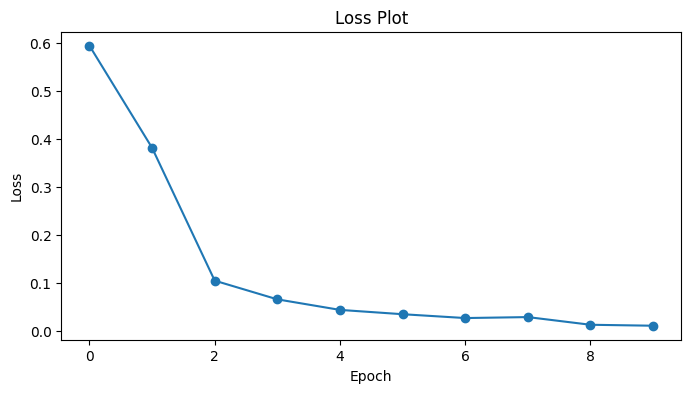

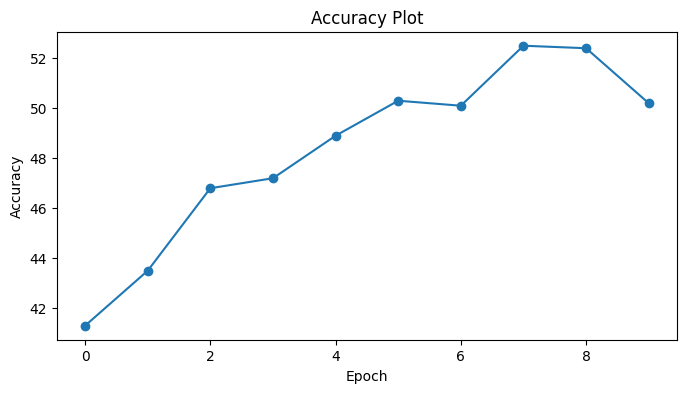

In [1]:
loss = [0.594, 0.381, 0.104, 0.065, 0.043, 0.034, 0.026, 0.028, 0.012, 0.010]
acc = [41.3, 43.5, 46.8, 47.2, 48.9, 50.3, 50.1, 52.5, 52.4, 50.2]


import matplotlib.pyplot as plt

loss = [0.594, 0.381, 0.104, 0.065, 0.043, 0.034, 0.026, 0.028, 0.012, 0.010]
acc = [41.3, 43.5, 46.8, 47.2, 48.9, 50.3, 50.1, 52.5, 52.4, 50.2]

# Plotting the loss
plt.figure(figsize=(8, 4))
plt.plot(loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Plotting the accuracy
plt.figure(figsize=(8, 4))
plt.plot(acc, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.show()

